# Knockoff on Linear Gaussian Model


+ generate knockoff with closed formula, in case x ~ Normal

In [1]:
import os
import sys

module_paths = [
    '../external/deepknockoffs/DeepKnockoffs/DeepKnockoffs',  # kfilter
    '../external/deepknockoffs/examples'
]
module_paths = [os.path.abspath(os.path.join(x)) for x in module_paths]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)


import math
import numpy as np
import matplotlib.pyplot as plt

from DeepKnockoffs.gaussian import GaussianKnockoffs
from DeepKnockoffs.kfilter import kfilter

import shap

In [4]:
from sklearn import preprocessing
from glmnet import LogitNet

def lasso_stats(X,Xk,y,alpha=0.1,scale=True):
    #
    # W: lasso difference coefficient
    # Z: 
    #
    X  = X.astype("float")
    Xk = Xk.astype("float")
    p = X.shape[1]
    if scale:
        X_concat = preprocessing.scale(np.concatenate((X,Xk),1))
    else:
        X_concat = np.concatenate((X,Xk),1)
    cols_order = np.random.choice(X_concat.shape[1],X_concat.shape[1],replace=False)
    m = LogitNet(alpha=0.1, n_splits=3)
    m.fit(X_concat[:,cols_order].copy(), y.copy())
    Z = np.zeros((2*p,))
    Z[cols_order] = m.coef_.squeeze()
    W = np.abs(Z[0:p]) - np.abs(Z[p:(2*p)])
    return W.squeeze(), Z

In [5]:
# number of data point
n = 1000
# number of variables 
p = 1000
# number of variables with nonzero coefficients
k = 60
# magnitude of nonzero coefficients
amplitude = 15
# noise level 
sigma = 1
# target FDR 
q = 0.2

In [6]:
np.random.seed(0)

Sigma = np.eye(p)
mu = np.zeros(p)
S0 = np.random.choice(p, k, replace=False)
beta = np.zeros(p)
beta[S0] = amplitude/np.sqrt(n)

def sigmoid(x):
    return np.exp(x)/(1 + np.exp(x))

def logistic_model(X):
    return sigmoid(X@beta)

def sample_logistic(X):
    return np.random.binomial(1, logistic_model(X))


def summary(S,verbose=True):
    
    true_discovery = sum(beta[S] > 0)
    power = true_discovery*100/k
    FDP = sum(beta[S] == 0) / max(1, np.size(S))
    
    if verbose:
        print(f"""
            true_discovery = {true_discovery}/{k} (power = {power}%)
            FDP = {FDP} (target FDR = {q})
        """)
    
    return power, FDP

In [7]:
# Data
X = np.random.multivariate_normal(mu, Sigma, size=n)
y = sample_logistic(X)
np.shape(X), np.shape(y)

((1000, 1000), (1000,))

In [8]:
# 1) Generate knockoffs X_k
knockoff_generator = GaussianKnockoffs(Sigma, method='equi') # method='equi' too slow
X_k = knockoff_generator.generate(X)
# 2) Compute pairwise statistics W
W, Z = lasso_stats(X,X_k,y,alpha=0,scale=False)
# 3) Compute threshold 
t = kfilter(W, q=q)
print(f'threshold: {t}')
# 4) Perform Test
S = np.where(W >= t)[0]
summary(S)

threshold: 0.002813718552784345

            true_discovery = 45/60 (power = 75.0%)
            FDP = 0.18181818181818182 (target FDR = 0.2)
        


(75.0, 0.18181818181818182)

In [ ]:
# Use SHAP to compute pairwise statistics
#
np.random.seed(0)

# 1) Generate knockoffs X_k
knockoff_generator = GaussianKnockoffs(Sigma, method='equi') # method='equi' too slow
X_k = knockoff_generator.generate(X)

# for sample_id in range(30):
#     print(f'sample_id={sample_id}')

#     # 2) Compute pairwise statistics W, based on X[sample_id,:] X_k[sample_id,:]
#     explainer   = shap.KernelExplainer(logistic_model, shap.kmeans(X, 3))
#     explainer_k = shap.KernelExplainer(logistic_model, shap.kmeans(X_k, 3))
#     shap_values = explainer.shap_values(X[sample_id,:])
#     shap_values_k = explainer.shap_values(X_k[sample_id,:])
#     # # difference in magnitude
#     W = np.abs(shap_values) - np.abs(shap_values_k)

#     # 3) Compute threshold 
#     t = kfilter(W, q=q,offset=0)
#     print(f'threshold: {t}')
#     # 4) Perform Test
#     S = np.where(W >= t)[0]
#     summary(S)

explainer   = shap.KernelExplainer(logistic_model, shap.kmeans(X, 3))
explainer_k = shap.KernelExplainer(logistic_model, shap.kmeans(X_k, 3))
shap_values = explainer.shap_values(X[:100,:])
shap_values_k = explainer.shap_values(X_k[:100,:])   
W_acc = np.mean(shap_values,axis=0) - np.mean(shap_values_k,axis=0)

print('accumulated pairwise statistics')
# 3) Compute threshold 
t = kfilter(W_acc, q=q,offset=0)
print(f'threshold: {t}')
# 4) Perform Test
S = np.where(W >= t)[0]
summary(S)

In [191]:
# 1) to see if by 'denoise' the statistics, we can acheive similar performance as LCD
#     if use 50 samples, get 32/60 w/ FDP=0%
#           100 samples, get 41/60 w/ FDP=31%
# 2) another thing to check is given a single instance, can achieve any performance 

W_acc = np.mean(np.abs(shap_values),axis=0) - np.mean(np.abs(shap_values_k),axis=0)

print('accumulated pairwise statistics')
# 3) Compute threshold 
t = kfilter(W_acc, q=q,offset=0)
print(f'threshold: {t}')
# 4) Perform Test
S = np.where(W >= t)[0]
summary(S)

# pws = []
# fdps = []
# for sample_id in range(100):
#     W = np.abs(shap_values[sample_id,:]) - np.mean(np.abs(shap_values_k),axis=0)
#     t = kfilter(W, q=q,offset=0)
#     print(f'threshold: {t}')
#     S = np.where(W >= t)[0]
#     pw,fdp = summary(S,verbose=False)
#     pws.append(pw)
#     fdps.append(fdp)
    
# pws/100, fdps/100


accumulated pairwise statistics
threshold: 0.005782679011963984

            true_discovery = 28/60 (power = 46.666666666666664%)
            FDP = 0.391304347826087 (target FDR = 0.2)
        


(46.666666666666664, 0.391304347826087)

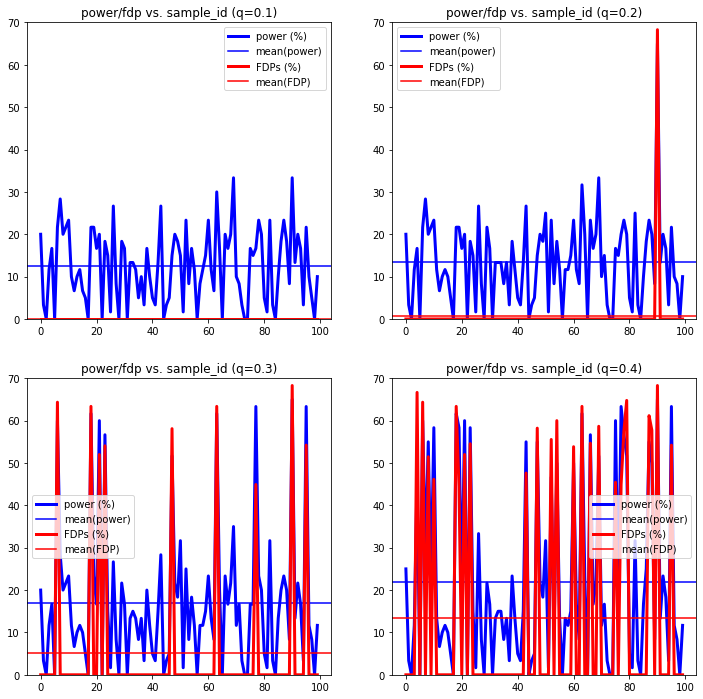

In [188]:
plt.figure(figsize=(12,12))

for i,q in enumerate([.1,.2,.3,.4]):
    pws = []
    fdps = []
    for sample_id in range(100):
        W = np.abs(shap_values[sample_id,:]) - np.mean(np.abs(shap_values_k),axis=0)
        t = kfilter(W, q=q,offset=0)
        S = np.where(W >= t)[0]
        pw,fdp = summary(S,verbose=False)
        pws.append(pw)
        fdps.append(fdp)

    pws = np.array(pws)
    fdps = np.array(fdps)
    
    plt.subplot(2,2,i+1)
    plt.title(f'power/fdp vs. sample_id (q={q})')
    plt.plot(pws,color='b',linewidth=3,label='power (%)')
    plt.axhline(y=np.mean(pws), color='b',label='mean(power)')
    plt.plot(fdps*100, color='r',linewidth=3,label='FDPs (%)')
    plt.axhline(y=np.mean(fdps)*100,color='r',label='mean(FDP)')
    plt.ylim([0, 70])
    plt.legend()

In [ ]:

I = np.argsort(W_acc)
np.intersect1d(S0,I[:100]), S0, I[:100], W_acc[I[:100]]


# shap_values[:30], shap_values_k[:30]

In [ ]:

compute_first_n_shap_values = 10
shap_values = explainer.shap_values(X[:compute_first_n_shap_values,:])

In [ ]:
shap.initjs()
shap.force_plot(float(explainer.expected_value), shap_values[:10,:], X[:10,:])
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")


In [ ]:
sample_ind = 0
shap.waterfall_plot(explainer.expected_value, shap_values[sample_ind], X[sample_ind,:], max_display=14)


In [ ]:
shap.summary_plot(shap_values, X[:10,:], max_display=14)